In [1]:
!pip install torch torchvision pillow matplotlib --quiet

import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
class BaseCAM:
    def __init__(self, model_arch, layer_name):
        self.model_arch = model_arch
        self.gradients = {}
        self.activations = {}

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0].detach()

        def forward_hook(module, input, output):
            self.activations['value'] = output

        hierarchy = layer_name.split('_')
        if len(hierarchy) >= 2:
            layer_num = int(hierarchy[1])
            self.target_layer = self.model_arch.features[layer_num]
        else:
            self.target_layer = self.model_arch.features

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def forward(self, input, class_idx=None):
        raise NotImplementedError

    def __call__(self, input, class_idx=None):
        return self.forward(input, class_idx)

In [3]:
class LayerCAM(BaseCAM):
    def forward(self, input, class_idx=None):
        b, c, h, w = input.size()
        logit = self.model_arch(input)
        if class_idx is None:
            class_idx = logit.max(1)[-1].item()
        score = logit[:, class_idx]
        self.model_arch.zero_grad()
        score.backward(retain_graph=True)

        activations = self.activations['value']
        gradients = self.gradients['value']

        with torch.no_grad():
            act_grad = activations * F.relu(gradients)
            cam = F.relu(torch.sum(act_grad, dim=1, keepdim=True))
            cam = F.interpolate(cam, size=(h, w), mode='bilinear', align_corners=False)

            cam_min, cam_max = cam.min(), cam.max()
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        return cam

In [4]:
def compute_layer_weights(cam_maps, eps=1e-12):
    weights = {}
    for stage, cam in cam_maps.items():
        weights[stage] = cam.sum().item()

    total = sum(weights.values()) + eps
    for stage in weights:
        weights[stage] = weights[stage] / total

    print("\nLayer Weights :\n")

    for stage, w in weights.items():
        print(f"{stage}: {w:.4f}")

    print("\n\n")

    return weights


def adaptive_refinement(cam_maps, weights):
    refined_maps = {}
    for stage, cam in cam_maps.items():
        w = weights[stage]
        refined_maps[stage] = (1 - w) * cam + w * (cam ** 2)
    return refined_maps


def soft_relu_fusion(refined_maps, weights, beta_mode='mean', softness=10.0):
    M_raw = torch.zeros_like(list(refined_maps.values())[0])
    for stage, refined_cam in refined_maps.items():
        M_raw += weights[stage] * refined_cam

    w_vals = np.array(list(weights.values()))
    if beta_mode == 'mean':
        beta = np.mean(w_vals)
    elif beta_mode == 'median':
        beta = np.median(w_vals)
    else:
        raise ValueError("beta_mode must be 'mean' or 'median'")

    M_fused = torch.sigmoid((M_raw - beta) * softness)
    f_min, f_max = M_fused.min(), M_fused.max()
    M_fused = (M_fused - f_min) / (f_max - f_min + 1e-8)

    return M_fused

In [5]:
def run_adalayer_cam(image_path, beta_mode='mean', softness=10.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).eval().to(device)
    for m in model.features:
        if isinstance(m, nn.ReLU):
            m.inplace = False

    conv_layers = [f"features_{i}" for i, m in enumerate(model.features) if isinstance(m, nn.Conv2d)]
    print(f"\nTotal number of Conv layers: {len(conv_layers)} \n")


    cam_maps = {}
    for layer_name in conv_layers:
        print(f"Computing CAM for {layer_name} ...")
        cam = LayerCAM(model, layer_name)(input_tensor)
        cam_maps[layer_name] = cam.cpu()

    from matplotlib import cm
    num_layers = len(cam_maps)
    cols = 5
    rows = int(np.ceil(num_layers / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    for idx, (layer_name, cam) in enumerate(cam_maps.items()):
        cam_np = cam.squeeze().numpy()
        heatmap = cm.jet(cam_np)[:, :, :3]
        axes[idx].imshow(heatmap)
        axes[idx].set_title(layer_name, fontsize=9)
        axes[idx].axis('off')
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    print("\n")
    plt.suptitle("CAM outputs of all convolutional layers", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    weights = compute_layer_weights(cam_maps)
    refined_maps = adaptive_refinement(cam_maps, weights)

    fused_cam = soft_relu_fusion(refined_maps, weights, beta_mode, softness)

    visualize_results(input_tensor, fused_cam)

    return fused_cam, weights, cam_maps

In [6]:
def visualize_results(input_tensor, fused_cam):
    from matplotlib import cm
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    img = input_tensor.squeeze().cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    cam = fused_cam.squeeze().cpu().numpy()
    heatmap = cm.jet(cam)[:, :, :3]

    overlay = 0.5 * img + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(heatmap)
    axes[1].set_title("AdaLayer-CAM Heatmap", fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay", fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Saving crab.png to crab.png
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 178MB/s]



Total number of Conv layers: 13 

Computing CAM for features_0 ...


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Computing CAM for features_2 ...
Computing CAM for features_5 ...
Computing CAM for features_7 ...
Computing CAM for features_10 ...
Computing CAM for features_12 ...
Computing CAM for features_14 ...
Computing CAM for features_17 ...
Computing CAM for features_19 ...
Computing CAM for features_21 ...
Computing CAM for features_24 ...
Computing CAM for features_26 ...
Computing CAM for features_28 ...




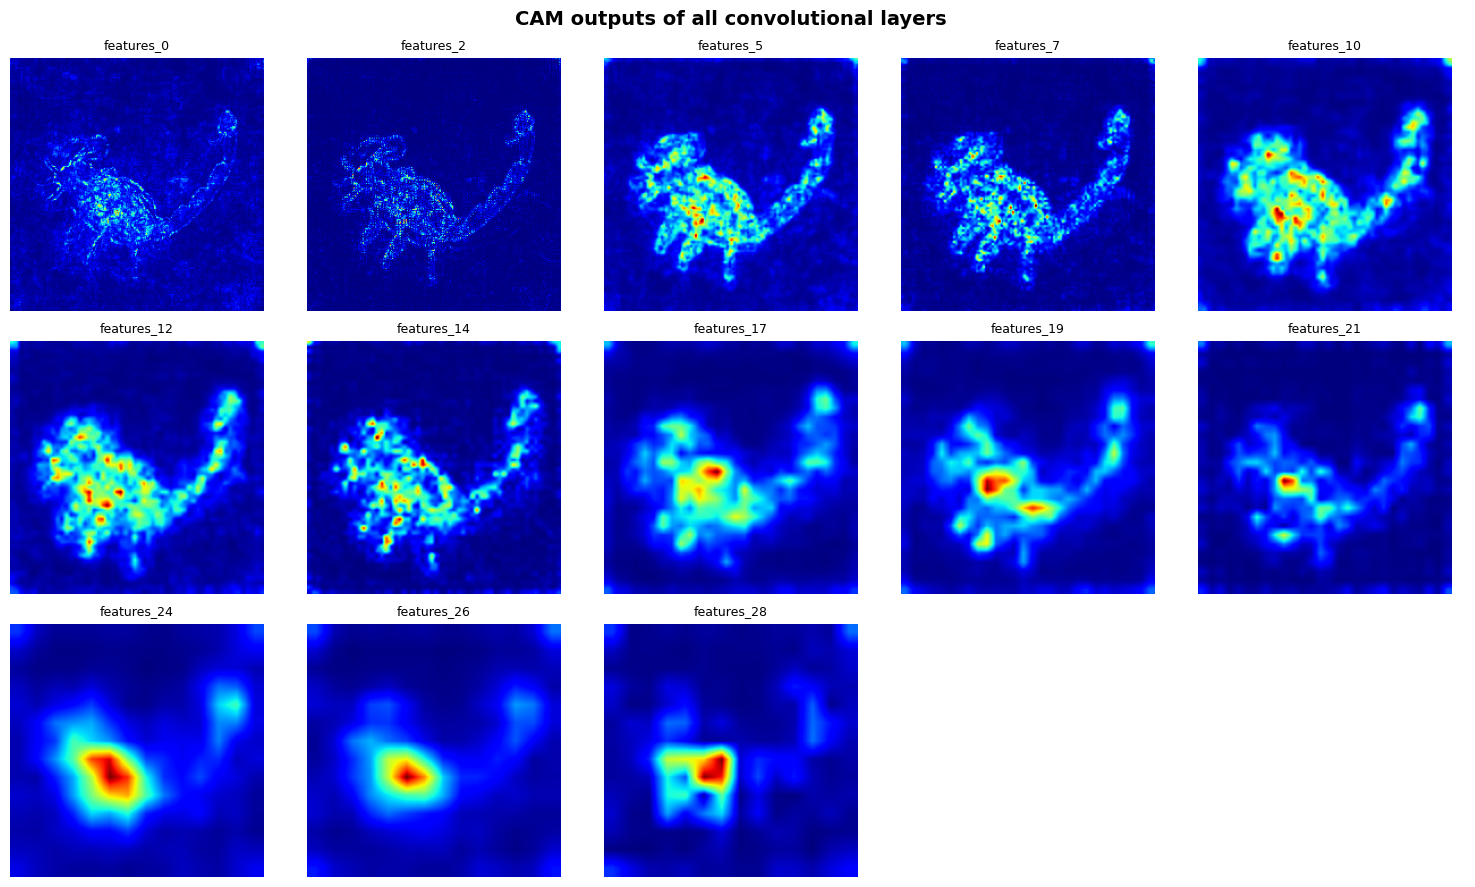


Layer Weights :

features_0: 0.0470
features_2: 0.0234
features_5: 0.0830
features_7: 0.0583
features_10: 0.1068
features_12: 0.1014
features_14: 0.0755
features_17: 0.0976
features_19: 0.0915
features_21: 0.0556
features_24: 0.1058
features_26: 0.0828
features_28: 0.0713





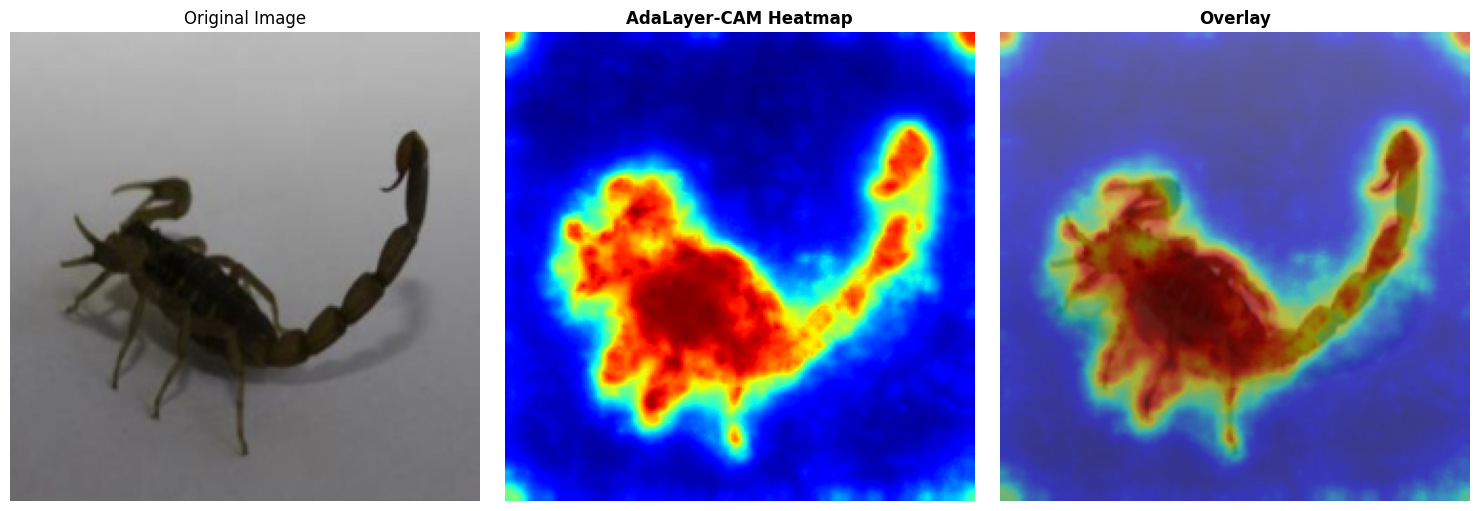

In [7]:
from google.colab import files

uploaded = files.upload()
if uploaded:
    image_path = list(uploaded.keys())[0]
    fused_cam, weights, cam_maps = run_adalayer_cam(image_path, beta_mode='mean', softness=10.0)
else:
    print("No image was uploaded.")